In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data.zip

In [3]:
import cv2,os

data_path='/content/data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict = (dict(zip(categories,labels)))
print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


In [4]:
img_size=100
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            resized=cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception:',e)

In [5]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)
np.save('data',data)
np.save('target',new_target)

In [6]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=data.shape[1:]))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 64)        

In [10]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=14,callbacks=[checkpoint],validation_split=0.1)

Epoch 1/14
170/170 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.5599
Epoch 00001: val_loss improved from inf to 0.65108, saving model to model-001.model
INFO:tensorflow:Assets written to: model-001.model/assets
170/170 [==============================] - 19s 51ms/step - loss: 0.6819 - accuracy: 0.5599 - val_loss: 0.6511 - val_accuracy: 0.6430
Epoch 2/14
169/170 [============================>.] - ETA: 0s - loss: 0.6020 - accuracy: 0.6790
Epoch 00002: val_loss improved from 0.65108 to 0.50688, saving model to model-002.model
INFO:tensorflow:Assets written to: model-002.model/assets
170/170 [==============================] - 8s 47ms/step - loss: 0.6015 - accuracy: 0.6796 - val_loss: 0.5069 - val_accuracy: 0.7686
Epoch 3/14
169/170 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.7986
Epoch 00003: val_loss improved from 0.50688 to 0.38788, saving model to model-003.model
INFO:tensorflow:Assets written to: model-003.model/assets
170/170 [====

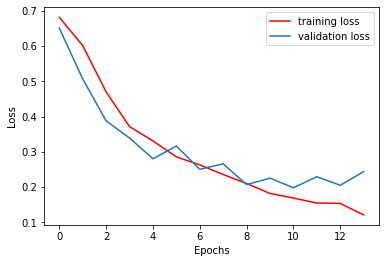

In [11]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

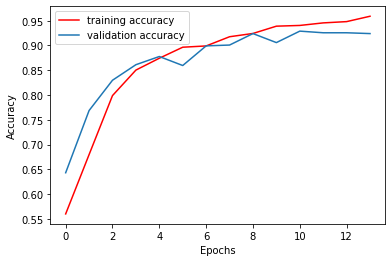

In [12]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
print(model.evaluate(test_data,test_target))

48/48 [==============================] - 1s 20ms/step - loss: 0.2865 - accuracy: 0.9080
[0.2864694893360138, 0.9080079197883606]


In [14]:
model.save('cnnmodel.h5')